In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import binom

In [4]:
## Matplotlib parameters
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [2]:
model_id ='ContinuousSBM_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'
#'ContinuousSBM_FFResUNet_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'
input_dir ='/mnt/home/dheurtel/ceph/04_inference/sbc/'+model_id+'/'

In [3]:
## Select high in f if you want only high noises, not high in f if you want only low noises and nothing if you want both
sbc_files = [f for f in os.listdir(input_dir) if ('SigmaMN' in f and 'high' not in f)] 
sbc_files.sort()
print(sbc_files)

counts = np.unique(np.array([int(f.split("_")[-1].split('.')[0]) for f in sbc_files]))
print("counts", counts)

['sbc_sims_SigmaMN_0.pt', 'sbc_sims_SigmaMN_1.pt', 'sbc_sims_SigmaMN_2.pt']
counts [0 1 2]


In [5]:
max_num_samples = 180 ## Maximum number of samples to consider from SBC, adjust by increasing 
# so that all samples are counted (useful when analyzing sbc while it is running)

# Load files
phi_truth_all = None
phi_samples_all = None
sigma_truth_all = None
sigma_samples_all = None
for sbc_file in sbc_files:
    print(sbc_file)
    sbc_file = os.path.join(input_dir, sbc_file)
    sbc_data = torch.load(sbc_file)
    phi_truth = sbc_data["rphi_true"].detach().cpu()
    sigma_truth = sbc_data["sigma_true"].detach().cpu()
    phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
    sigma_samples = sbc_data["tensor_sigma_list"].detach().cpu()
    if phi_truth_all is None:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = phi_truth
        phi_samples_all = phi_samples[:max_num_samples, :, :]
        sigma_truth_all = sigma_truth
        sigma_samples_all = sigma_samples[:max_num_samples, :, :]
    else:
        if phi_samples.shape[0] < max_num_samples:
            continue
        phi_truth_all = torch.cat((phi_truth_all, phi_truth), dim=0)
        phi_samples_all = torch.cat((phi_samples_all, phi_samples[:max_num_samples, :, :]), dim=1)
        sigma_truth_all = torch.cat((sigma_truth_all, sigma_truth), dim=0)
        sigma_samples_all = torch.cat((sigma_samples_all, sigma_samples[:max_num_samples, :, :]), dim=1)
try:
    print(phi_truth_all.shape, phi_samples_all[:max_num_samples, :, :].shape, sigma_truth_all.shape, sigma_samples_all[:max_num_samples, :, :].shape)
except:
    print("No samples")

sbc_sims_SigmaMN_0.pt
sbc_sims_SigmaMN_1.pt
sbc_sims_SigmaMN_2.pt
torch.Size([1200, 2]) torch.Size([180, 1200, 2]) torch.Size([1200, 1]) torch.Size([180, 1200, 1])


In [6]:
nb_burning_samples = 50

# Get rid of the burnin samples
phi_samples_all = phi_samples_all[nb_burning_samples:, :, :]
sigma_samples_all = sigma_samples_all[nb_burning_samples:, :, :]

In [7]:
sigma_samples_all.shape

torch.Size([130, 1200, 1])

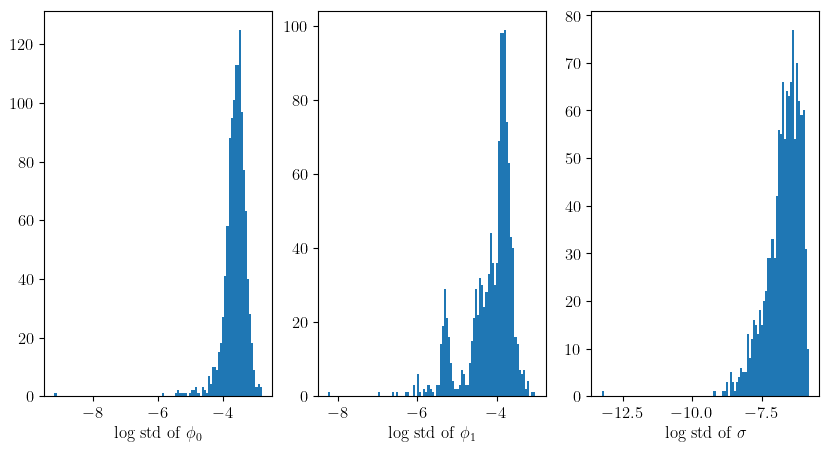

In [10]:
# Show histogram of stds
eps = 1e-9
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].hist(torch.log(phi_samples_all[..., 0].std(dim=0) + eps), bins=100)
axs[0].set_xlabel("log std of $\phi_0$")
axs[1].hist(torch.log(phi_samples_all[..., 1].std(dim=0) + eps), bins=100)
axs[1].set_xlabel("log std of $\phi_1$")
axs[2].hist(torch.log(sigma_samples_all[...,0].std(dim=0) + eps), bins=100)
axs[2].set_xlabel("log std of $\sigma$")
plt.show()

In [11]:
# Remove chains that have not converged (threshold on std of phi)
threshold = -6
converged_indices = torch.where(torch.logical_and(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) >= threshold,
                                                torch.log(phi_samples_all[..., 1].std(dim=0) + eps) >= threshold))[0]
not_converged_indices = torch.where(torch.logical_or(torch.log(phi_samples_all[..., 0].std(dim=0) + eps) < threshold,
                                                    torch.log(phi_samples_all[..., 1].std(dim=0) + eps) < threshold))[0]
print("Number of chains that have not converged:", not_converged_indices.shape[0])

Number of chains that have not converged: 11


In [12]:
# Compute rank statistics for phi
phi_truth_all_converged = phi_truth_all[converged_indices, :]
phi_samples_all_converged = phi_samples_all[:, converged_indices, :]
ranks = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
for i in range(phi_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
    for j in range(phi_truth_all_converged.shape[1]):
        autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
        ranks[i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [13]:
# Compute rank statistics for sigma
sigma_truth_all_converged = sigma_truth_all[converged_indices, :]
sigma_samples_all_converged = sigma_samples_all[:, converged_indices, :]
ranks_sigma = torch.zeros(sigma_truth_all_converged.shape[0])
autocorrelation_length_sigma = torch.zeros(sigma_truth_all_converged.shape[0])
for i in range(sigma_truth_all_converged.shape[0]):
    az_infdata = az.convert_to_inference_data(sigma_samples_all_converged[:, i][None, :].numpy())
    autocorrelation_length_sigma[i] = len(sigma_samples_all_converged[:, i]) / az.ess(az_infdata)['x'].values[0]
    ranks_sigma[i] = torch.mean((sigma_samples_all_converged[::max(int(autocorrelation_length_sigma[i]), 1), i] < sigma_truth_all_converged[i]).float())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


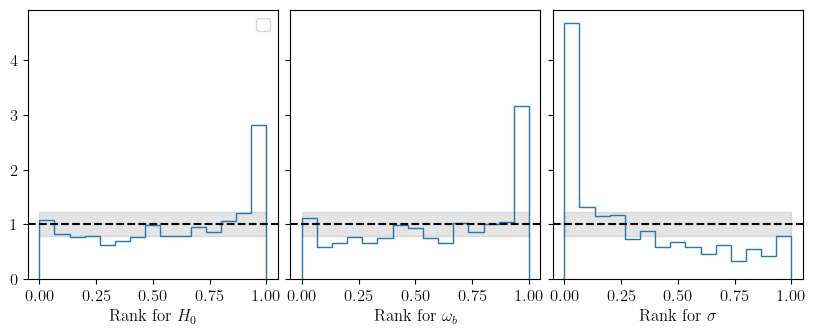

In [17]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True, sharey=True)
nbins = 15
axs[0].hist(ranks[:, 0], bins=nbins, density=True, histtype='step')
axs[1].hist(ranks[:, 1], bins=nbins, density=True, histtype='step')
axs[2].hist(ranks_sigma, bins=nbins, density=True, histtype='step')
N = ranks.shape[0]
q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
axs[0].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[1].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[2].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank for $H_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank for $\omega_b$")
axs[2].axhline(1.0, color='black', linestyle='--')
axs[2].set_xlabel("Rank for $\sigma$")
axs[0].legend()
fig.subplots_adjust(wspace=0.05)
if save_fig:
    plt.savefig("sbc_ranks.pdf", bbox_inches='tight')
plt.show()